### Fist, authenticate to google and import librabies

In [1]:
# ! pip install geemap
# import geemap
import ee
import numpy as np
import pandas as pd
from pprint import pprint
from osgeo import gdal, osr

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *

import json
import sys
import glob
import os

In [2]:
from google.colab import drive
drive.mount('/content/G_drive')

# cp tokens
!mkdir /root/.config/earthengine/
!cp '/content/G_drive/MyDrive/Colab Notebooks/Google_Earth_Engine_tokes/credentials' /root/.config/earthengine/credentials 

# authenticate earthengine api
ee.Initialize()

# create the tmp folder
! mkdir /content/tf_tmp

Mounted at /content/G_drive


In [ ]:
# Cloud authentication.
from google.colab import auth
auth.authenticate_user()

In [3]:
# Tensorflow setup.
import tensorflow as tf
print(tf.__version__)

2.5.0


In [4]:
# print the GPI-info
! nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-2155340e-ac03-c357-375f-0d3607004fa0)


### Then, difine the basic parameter/path-to-data

In [5]:
# import urban-img and terrain data
urban = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [6]:
# define the year-range
year = [f'{i}_{i+2}' for i in range(1990,2020,3)]
year_img_val_dict = {yr:i for yr,i in zip(year,range(10,0,-1))}

In [7]:
# define the limit_list that controls the periods for prediction
limit_list = [19]

In [8]:
# get all possible years for traning the projection
proj_yr = []
for k,v in year_img_val_dict.items():
    # get the t0 val/img
    t0 = k
        
    # get the t1;t2
    if v == 2:
        pass
    else:
        for val in range(v-1,1,-1):
            prj_val = val - (v - val)
            
            if  prj_val>0:
                
                prj_yr  = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                
                t1 = [k for k,v in year_img_val_dict.items() if v==val][0]
                t2 = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                                
                proj_yr.append((t0,t1,t2))

In [9]:
# show the years used for train/pred
proj_yr[limit_list[0]]

('2011_2013', '2014_2016', '2017_2019')

In [10]:
# is the samples comes from mixed year? e.g. randomly sample training patches from 1990-2019. 
MIX_YEAR = False  # True/False

# if MIX_YEAR is included, is the year(e.g., 2017) used as a layer?
YEAR = False  # True/False

# include road as a predictor?
ROAD = True  # True/False

# if to project to future?
Future = False # True/False


# judge to set the Feature for prediction/name for export
if ROAD:
  FEATURES   = ['built_up_t0', 'elevation', 'slope', 'distance', 'built_up_t1']
  FEATURES_pred = ['built_up_t1', 'elevation', 'slope', 'distance', 'built_up_t2']
  model_folder = '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_with_distance_to_roads' 
  sample_folder = 'urban_prj_distance' 
else:
  FEATURES   = ['built_up_t0', 'elevation', 'slope', 'built_up_t1']
  FEATURES_pred = ['built_up_t1', 'elevation', 'slope', 'built_up_t2']
  model_folder = '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_no_distance_to_roads'
  sample_folder = 'urban_prj'


# judge to include the "year(num)" as a predictor
if MIX_YEAR and YEAR:
  FEATURES.insert(-1,'year')
  FEATURES_pred.insert(-1,'year')
  model_folder = '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_year' 
  sample_folder = 'urban_prj_mix_year'
elif MIX_YEAR:
  model_folder = '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year' 
  sample_folder = 'urban_prj_mix_no_year'


# Specify the export folder that stores the whole img to be classified
EXPORT_FOLDER = f'/content/G_drive/MyDrive/{sample_folder}'

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

FEATURES_DICT = {k:tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in  FEATURES}
FEATURES_DICT_pred = {k:tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES_pred}

# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 20000
EVAL_SIZE = 2500
PRED_SIZE = 1000

# Specify model training parameters.
BATCH_SIZE = 50
EPOCHS = 10
BUFFER_SIZE = 5000
OPTIMIZER = 'adam'
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [11]:
# create the training patch

train_data = []

for t in proj_yr:
    
    # get the time
    t0 = t[0]
    t1 = t[1]
    t2 = t[2]
    proj_times = year_img_val_dict[t0] - year_img_val_dict[t1]
    proj_years = proj_times*3
    
    # get the built-up layer
    t0_img,t1_img,t2_img = [urban.gte(year_img_val_dict[yr]).rename(f'built_up_t{i}') for i,yr in enumerate(t)]
    
    # get the expansion mask
    expansion_mask = t1_img.subtract(t0_img).rename('expansion')
    expansion_prj  = t2_img.subtract(t1_img).rename('expansion')

    # get the last year to indicate the data of urban image
    year_t0 = ee.Image(int(t0.split('_')[1])).rename('year')
    year_t1 = ee.Image(int(t1.split('_')[1])).rename('year')
    year_t2 = ee.Image(int(t2.split('_')[1])).rename('year')

    # import DEM and SLOPE
    DEM = ee.Image("USGS/SRTMGL1_003")
    SLOPE = ee.Terrain.slope(DEM)
    
    # stack all bands for later tranin/eval
    if not ROAD:
      train_eval_bands = t0_img.addBands(DEM).addBands(SLOPE).addBands(t1_img).select(FEATURES).toFloat()  # IMPORTANT: .toFloat() is necessary!
      pred_bands    = t1_img.addBands(DEM).addBands(SLOPE).addBands(t2_img).select(FEATURES_pred).toFloat() # it should be validata band, but to consist with later codes, cant change it.
      proj_bands    = t2_img.addBands(DEM).addBands(SLOPE).rename(FEATURES_pred[:-1]).toFloat()
      
    elif ROAD:
      # import the Distance_to_built-up imgs//  NOTE!!!! currently we only have the road back to 2013
      Distance_t0 = ee.Image("users/wangjinzhulala/GEE_TF/Distance_imgs/Dist_road_2013").rename('distance')
      Distance_t1 = ee.Image("users/wangjinzhulala/GEE_TF/Distance_imgs/Dist_road_2016").rename('distance')

      train_eval_bands = t0_img.addBands(DEM).addBands(SLOPE).addBands(Distance_t0).addBands(year_t0).addBands(t1_img).select(FEATURES).toFloat()
      pred_bands    = t1_img.addBands(DEM).addBands(SLOPE).addBands(Distance_t1).addBands(year_t1).addBands(t2_img).select(FEATURES_pred).toFloat()
      proj_bands    = t2_img.addBands(DEM).addBands(SLOPE).rename(FEATURES_pred[:-1]).toFloat()

    
    # convert img to neighboorhood-array
    list_1d = ee.List.repeat(1, KERNEL_SIZE)
    list_2d = ee.List.repeat(list_1d, KERNEL_SIZE)
    kernel  = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, list_2d)

    arrays_train_eval = train_eval_bands.neighborhoodToArray(kernel)
    arrays_future   = proj_bands.neighborhoodToArray(kernel)
    
    # add patch to a dict
    train_data.append([t0,t1,t2,proj_years,arrays_train_eval,arrays_future,pred_bands,proj_bands])

In [12]:
train_data = pd.DataFrame(train_data,columns = ['t0','t1','t2','proj_years','arrays_train_eval','arrays_future','img_to_proj','img_to_future'])
train_data

,t0,t1,t2,proj_years,arrays_train_eval,arrays_future,img_to_proj,img_to_future
0,1990_1992,1993_1995,1996_1998,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,1990_1992,1996_1998,2002_2004,6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,1990_1992,1999_2001,2008_2010,9,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,1990_1992,2002_2004,2014_2016,12,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,1993_1995,1996_1998,1999_2001,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
5,1993_1995,1999_2001,2005_2007,6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
6,1993_1995,2002_2004,2011_2013,9,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
7,1993_1995,2005_2007,2017_2019,12,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
8,1996_1998,1999_2001,2002_2004,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
9,1996_1998,2002_2004,2008_2010,6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


### Step_1: Extract img patches to GCP bucket

#### Export the traning sampel to G-Cloud

In [13]:
# import the research area, simplify the gemegery to reduce calculation cost
Region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")
Simplified_geo = Region.geometry().simplify(50000)
Simplified_buffer = Simplified_geo.buffer(-15000)

# split the export into patch and shards to avoide "capacity exceed"
total_shards = 1000

# get the patch number
if not MIX_YEAR:
  patch_n = 10
else:
  patch_n = len(train_data)

# get the shard per patch
shard_per_patch = int(total_shards/patch_n)

# set the seed list which is 2-time longer than the toall shards
seed_pool = range(total_shards*2)

In [14]:
# construc a function to export training samples
def export_sample(img,which_patch,export_type='training',to_future=Future):

  # create an empty to hold the samples
  geomSample = ee.FeatureCollection([])

  for i in range(shard_per_patch):

    # get the seed and sample_size for this patch
    if export_type == 'training':
      seed = seed_pool[which_patch*shard_per_patch + i]
      sample_size = TRAIN_SIZE
    elif export_type == 'eval':
      seed = seed_pool[which_patch*shard_per_patch + i + total_shards]
      sample_size = EVAL_SIZE
    else:
      print('Wrong export type, chose from ["training","eval"]')
      break

    # sample from img
    sample = img.sample(
      region = Simplified_buffer, 
      scale = 30,
      numPixels = int(sample_size/total_shards),
      seed = seed,
      tileScale = 8
    )
    geomSample = geomSample.merge(sample)

  # export the sample
  if MIX_YEAR:
    desc = f"{export_type}_patches_mix_years_{row['t0']}_and_{row['t1']}_prj_{row['t2']}_{which_patch:03}"
  elif to_future:
    desc = f"{export_type}_patches_{row['t2']}_future_{which_patch:03}"
  elif ROAD:
    desc = f"{export_type}_patches_with_distance_{row['t0']}_and_{row['t1']}_prj_{row['t2']}_{which_patch:03}"
  else:
    desc = f"{export_type}_patches_{row['t0']}_and_{row['t1']}_prj_{row['t2']}_{which_patch:03}"

  task = ee.batch.Export.table.toDrive(
      collection = geomSample,
      description = desc,
      folder = sample_folder,
      fileNamePrefix = desc,
      fileFormat = 'TFRecord',
      selectors = FEATURES
  )
  task.start()

  print(desc)

In [ ]:
# export the training and eval samples
for sample_type in ["training","eval"]:

  # check if this was to export sample of mixed-years
  if MIX_YEAR:
    # because we want sample from mixed-year, its better to shuffle the data first
    shuffle_data = train_data.sample(frac=1,random_state=123).reset_index(drop=True)

    # get the training sample
    for idx,row in shuffle_data.iloc[limit_list].iterrows():
      for patch in range(patch_n):
          
        if not Future:
          img = row['arrays_train_eval']
        else:
          img = row['arrays_future']

        # export samples
        export_sample(img,patch,export_type=sample_type)

  else:
    # get the training sample
    for idx,row in train_data.iloc[limit_list].iterrows():
      for patch in range(patch_n):
          
        if not Future:
          img = row['arrays_train_eval']
        else:
          img = row['arrays_future']
        
        # export samples
        export_sample(img,patch,export_type=sample_type,to_future=Future)  

training_patches_2011_2013_and_2014_2016_prj_2017_2019_000
training_patches_2011_2013_and_2014_2016_prj_2017_2019_001
training_patches_2011_2013_and_2014_2016_prj_2017_2019_002
training_patches_2011_2013_and_2014_2016_prj_2017_2019_003
training_patches_2011_2013_and_2014_2016_prj_2017_2019_004
training_patches_2011_2013_and_2014_2016_prj_2017_2019_005
training_patches_2011_2013_and_2014_2016_prj_2017_2019_006
training_patches_2011_2013_and_2014_2016_prj_2017_2019_007
training_patches_2011_2013_and_2014_2016_prj_2017_2019_008
training_patches_2011_2013_and_2014_2016_prj_2017_2019_009
eval_patches_2011_2013_and_2014_2016_prj_2017_2019_000
eval_patches_2011_2013_and_2014_2016_prj_2017_2019_001
eval_patches_2011_2013_and_2014_2016_prj_2017_2019_002
eval_patches_2011_2013_and_2014_2016_prj_2017_2019_003
eval_patches_2011_2013_and_2014_2016_prj_2017_2019_004
eval_patches_2011_2013_and_2014_2016_prj_2017_2019_005
eval_patches_2011_2013_and_2014_2016_prj_2017_2019_006
eval_patches_2011_2013_an

#### Load the data exported from Earth Engine into a tf.data.Dataset. The following are helper functions for that.

In [15]:
def parse_tfrecord(example_proto,fe_dict):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, fe_dict)


def to_tuple(inputs,fe):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in fe]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(fe)-1], stacked[:,:,len(fe)-1:]


def get_dataset(pattern,fe,fe_dict):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns:
    A tf.data.Dataset
  """
  globs = glob.glob(pattern)
  dataset = tf.data.TFRecordDataset(globs, compression_type='GZIP')
  dataset = dataset.map(lambda x: parse_tfrecord(x,fe_dict), num_parallel_calls=5)
  dataset = dataset.map(lambda x: to_tuple(x,fe), num_parallel_calls=5)
  return dataset

Use the helpers to read dataset.

In [16]:
def get_training_dataset(TRAINING_BASE):
	"""Get the preprocessed training dataset
  Returns: 
    A tf.data.Dataset of training data.
  """
	glob = f'{EXPORT_FOLDER}/{TRAINING_BASE}*'
	dataset = get_dataset(glob,FEATURES,FEATURES_DICT)
	dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
	return dataset

In [17]:
def get_eval_dataset(EVAL_BASE):
	"""Get the preprocessed evaluation dataset
  Returns: 
    A tf.data.Dataset of evaluation data.
  """
	glob = f'{EXPORT_FOLDER}/{EVAL_BASE}*'
	dataset = get_dataset(glob,FEATURES,FEATURES_DICT)
	dataset = dataset.batch(1).repeat()
	return dataset


### Step_2: Create the CNN model

In [18]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import optimizers

def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
	inputs = layers.Input(shape=[None, None, len(FEATURES)-1]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])

	model.compile(
		optimizer=OPTIMIZER,
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS])

	return model

In [19]:
# construct a function to train the FCNN model with 200 epoches 

def train_fcnn(start_epoch = 1,end_epoch = 20):
  # train the model and save model to disk for each 10-epoches
  for epoch in range(start_epoch,end_epoch + 1):

    # get the name
    if MIX_YEAR and YEAR:
      name = f'FCNN_mix_years'
      TRAINING_BASE = f"training_patches_mix_years_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"
      EVAL_BASE = f"eval_patches_mix_years_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"
    elif MIX_YEAR:
      name = f'FCNN_mix_years'
      TRAINING_BASE = f"training_patches_mix_no_years_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"
      EVAL_BASE = f"eval_patches_mix_no_years_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"
    elif Future:
      name = f'FCNN_{row["t2"]}_to_future'
      TRAINING_BASE = f"training_patches_{row['t2']}_future"
      EVAL_BASE = f"eval_patches_{row['t2']}_future"
    elif ROAD:
      name = f'FCNN_with_distance_{row["t0"]}_and_{row["t1"]}_prj_{row["t2"]}'
      TRAINING_BASE = f"training_patches_with_distance_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"
      EVAL_BASE = f"eval_patches_with_distance_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"
    else:
      name = f'FCNN_{row["t0"]}_and_{row["t1"]}_prj_{row["t2"]}'
      TRAINING_BASE = f"training_patches_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"
      EVAL_BASE = f"eval_patches_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"      
    

    # get the pre-trained model
    if epoch == 1:
      m = get_model()
    else:
      m = tf.keras.models.load_model(f'{model_folder}/{name}_{(epoch-1)*10:03}.pb')

    # get the train data
    training = get_training_dataset(TRAINING_BASE).repeat()
    # get the eval data
    evaluation = get_eval_dataset(EVAL_BASE).repeat()

    # fit the model
    print(f"Training model for {name}_{epoch*10:03}")
    m.fit(
        x=training, 
        epochs=10,
        steps_per_epoch=int(TRAIN_SIZE/BATCH_SIZE),
        validation_data = evaluation,
        validation_steps = EVAL_SIZE)
    
    # saving model and csv to disk
    unet_folder = f"{model_folder}/"
    csv_folder = f"{model_folder}_metrics_csv/"

    for folder in [unet_folder,csv_folder]:
      if not os.path.exists(folder):
        os.makedirs(folder,exist_ok=True)

    # save the training history
    loss = pd.DataFrame(m.history.history)
    loss.to_csv(f"{csv_folder}/{name}_{epoch*10:03}.csv",index=False)

    # save/load model
    m.save(f"{unet_folder}/{name}_{epoch*10:03}.pb")

    print('_______________________________________')


In [21]:
# if we are training model with the mix-year samples, we start the training directly
if MIX_YEAR:
  print('='.center(80,'='))
  print(' Training model of mix-year '.center(80,'='))
  print('='.center(80,'='))
  train_fcnn()

# if we are not train the model with mix-year samples, we will locate the year by 
# examine the index of the data-df, then train the model  
else:
  print('='.center(80,'='))
  print('Training model of non-mix-year'.center(80,'='))
  print('='.center(80,'='))

  # export traning sample
  for idx,row in train_data.iterrows():
    # define the condition to avoide export all samples
    if idx in limit_list:
      # train the fcnn with 200 epoches
      train_fcnn(start_epoch=19)

=========================Training model of non-mix-year=========================
Training model for FCNN_with_distance_2011_2013_and_2014_2016_prj_2017_2019_190
Epoch 1/10
400/400 [==============================] - 422s 913ms/step - loss: 0.0120 - root_mean_squared_error: 0.1096 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 2/10
400/400 [==============================] - 384s 881ms/step - loss: 0.0120 - root_mean_squared_error: 0.1098 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1479
Epoch 3/10
400/400 [==============================] - 382s 879ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 4/10
400/400 [==============================] - 380s 878ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 5/10
400/400 [==============================] - 379s 874ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 0.01

#### Check the losses change

In [ ]:
df_no_distance =  ! ls /content/G_drive/MyDrive/Urban_prj_models/FCNN_models_no_distance_to_roads_metrics_csv/FCNN_2017_2019_to_future*

In [ ]:
df_no_distance

In [ ]:
df_no_dist = pd.concat([pd.read_csv(f) for f in df_no_distance])
df_no_dist['type'] = 'No_dist'
df_no_dist['epoch'] = range(1,len(df_no_dist)+1)

In [ ]:
df = df_no_dist[df_no_dist['epoch']%10 == 0]

In [ ]:
df

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,type,epoch
9,0.024997,0.158105,0.023837,0.154394,No_dist,10
9,0.024400,0.156204,0.023390,0.152938,No_dist,20
9,0.023053,0.151832,0.023235,0.152432,No_dist,30
9,0.021420,0.146356,0.022565,0.150217,No_dist,40
9,0.019416,0.139341,0.022643,0.150475,No_dist,50
9,0.017718,0.133111,0.022527,0.150090,No_dist,60
9,0.016371,0.127949,0.022777,0.150920,No_dist,70
9,0.015300,0.123692,0.023217,0.152370,No_dist,80
9,0.014460,0.120248,0.023841,0.154406,No_dist,90
9,0.013807,0.117501,0.023952,0.154765,No_dist,100


/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


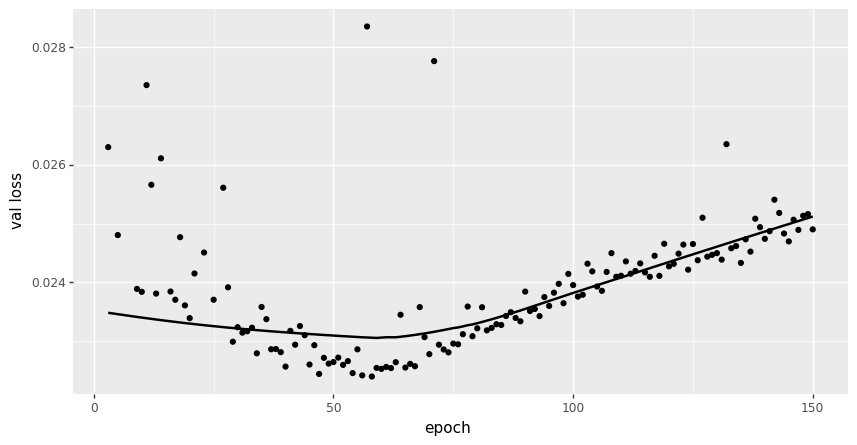

<ggplot: (8729393434469)>

In [ ]:
plotnine.options.figure_size = (10, 5)

(df_no_dist[df_no_dist['val_loss']<0.03] >> 
 ggplot()+
 geom_smooth(aes('epoch','val_loss'),se=True, size=1)+
 geom_point(aes('epoch','val_loss')) +
 scale_x_continuous(breaks = range(0,501,50)) +
 scale_color_hue(name="Model type",labels =['No years','With years']) +
 ylab('val loss') 
 
 )

#### Explore the results

In [ ]:
# # get the sample patchs
# pred_patch = m.predict(pred_tf.take(PRED_SIZE))
# true_patch = [i[1].numpy() for i in  iter(pred_tf.take(PRED_SIZE))]

# # plot randomly one of the patches
# num = np.random.randint(PRED_SIZE)

# plt.figure(figsize=(6,6))
# plt.imshow(pred_patch[num,:,:,0])

# true = true_patch[num]
# plt.figure(figsize=(6,6))
# plt.imshow(true[0,:,:,0])

### Step_3: Export the GEE-asset to Cloud-Storage as TF format, and make predictions

#### Export the gee-asset to tf-format, note the buffer

In [ ]:
# # a small region for testing the model predictions
# region = ee.Feature(ee.Geometry.Polygon(
#         [[[115.12664527404763, 34.81907241078023],
#           [115.12664527404763, 33.80730649645679],
#           [116.47796363342263, 33.80730649645679],
#           [116.47796363342263, 34.81907241078023]]]))

In [ ]:
# a helper function to export tif to TF
def doExport(img,out_image_base, kernel_buffer, region):
  """Run the image export task.  Block until complete.
  """
  # create a folder in G-Drive befor exporting
  if not os.path.exists(sample_folder):
    os.makedirs(sample_folder,exist_ok=True)

  task = ee.batch.Export.image.toDrive(
      image = img.select(FEATURES_pred[:-1]).toFloat(),
      description = out_image_base,
      folder = sample_folder,
      fileNamePrefix = out_image_base,
      region = region.geometry().bounds(),
      scale = 30,
      fileFormat = 'TFRecord',
      maxPixels = 1e10,
      formatOptions = {
        'patchDimensions': KERNEL_SHAPE,
        'kernelSize': kernel_buffer,
        'compressed': True,
        'maxFileSize': 104857600
    }
  )
  task.start()

#### Perform prediction/classification

In [ ]:
def doPrediction(model,out_image_base, user_folder, kernel_buffer, pred_chunk_num):
  """Perform inference on exported imagery, upload to Earth Engine.
  """

  print('Looking for TFRecord files...')

  # Get a list of all the files in the output bucket.
  filesList = !ls {EXPORT_FOLDER}

  # Get only the files generated by the image export.
  exportFilesList = [s for s in filesList if pred_image_base in s]

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  jsonFile = None
  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f'{EXPORT_FOLDER}/{f.strip()}')
    elif f.endswith('.json'):
      jsonFile = f'{EXPORT_FOLDER}/{f.strip()}'

  # Make sure the files are in the right order.
  imageFilesList.sort()

  from pprint import pprint
  pprint(imageFilesList)
  print(jsonFile)

  import json
  # Load the contents of the mixer file to a JSON object.
  jsonText = !cat {jsonFile}
  # Get a single string w/ newlines from the IPython.utils.text.SList
  mixer = json.loads(jsonText.nlstr)
  pprint(mixer)
  patches = mixer['totalPatches']

  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)

  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageFeaturesDict = { k:tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32) for k in FEATURES_pred[:-1] }
  

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(inputs):
    inputsList = [inputs.get(key) for key in FEATURES_pred[:-1]]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

  # Create a dataset from the TFRecord file(s)
  imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
  imageDataset = imageDataset.map(toTupleImage).batch(1)



  # Perform inference. Note split the imageDataset to chunks to avoid memory explosion
  out_image_file = f'/content/tf_tmp/{out_image_base}.TFRecord'
  writer = tf.io.TFRecordWriter(out_image_file)

  for start in range(0,patches,pred_chunk_num):
    
    # find out the slicing point
    slicing_pt = f'{start:05d}_{min(start + pred_chunk_num, patches):05d}'

    # slice a chunk from imageDataset
    in_pred = imageDataset.skip(start).take(pred_chunk_num)
    print(f'Running predictions {slicing_pt}')

    # make the prediction/classification
    predictions = model.predict(in_pred, steps=pred_chunk_num, verbose=1)

    flag = 1
    for predictionPatch in predictions:
      
      predictionPatch = predictionPatch[
          x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]

      # Create an example.
      example = tf.train.Example(
        features=tf.train.Features(
          feature={
            'pred': tf.train.Feature(
                float_list=tf.train.FloatList(
                    value=predictionPatch.flatten()))
          }
        )
      )
      # Write the example.
      writer.write(example.SerializeToString())

      # report the process
      if flag % 1000 == 0:
        print(f'Writing patch {slicing_pt}_{flag:04d}')
      flag += 1

  writer.close() 

In [ ]:
# Output assets folder
user_folder = 'users/wangjinzhulala/GEE_TF/Urban_projection'
# Half this will extend on the sides of each patch.
pred_kernel_buffer = [32, 32]
# Define the export_region
export_region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary") 

# define the number of chunks to be splited from the tf file
chunk_num = 3

In [ ]:
# First, we need to export all img to disk
for idx,row in train_data.iterrows():

  # define the condition to avoide export all samples
  if idx in limit_list:

    # Define basic parameters
    if Future:
      pred_image = row['img_to_future']
      pred_image_base = f'FCNN_{row["t2"]}_to_future'
    else:
      pred_image = row['img_to_proj']
      pred_image_base = f'FCNN_{row["t0"]}_and_{row["t1"]}_prj_{row["t2"]}'

    # Export
    doExport(pred_image, pred_image_base, pred_kernel_buffer, export_region)

    # print out the process
    print(f'Exporting {pred_image_base}')

Exporting FCNN_2017_2019_to_future


### Step_4: Save the tf_Record to geotif

In [ ]:
# function to read tf_data and extract the np.array
def tf_to_arry(tf_data,skip_row,take_row):

  # loop through tf_data to get np.array
  img_array = []
  for fe in tf_data.skip(width*skip_row).take(width*take_row):

    arry = fe['pred'].numpy()
    img_array.append(arry)

  # rearrange the np.array to a 2-d image
  out_array = np.array(img_array)
  img_array = None
  out_array = out_array.reshape(take_row,-1,256,256)
  out_array = list(map(lambda x:np.hstack(x),out_array))
  out_array = np.array(np.vstack(out_array))

  # convert the out_array to int-16 to reduce space
  out_array = (out_array*10000).astype(np.int16)

  # print out the memory that the array takes
  print(f'Memory taking: {out_array.nbytes/1024/1024/1024:.2f} GB')

  return out_array

In [ ]:
def arry_to_geotif(in_arry,tif_name,skip_row):
  # fetch the projection
  sr = osr.SpatialReference()
  sr.ImportFromEPSG(epsg)
  sr_wtk = sr.ExportToWkt()

  # get the transformation info
  proj = mixer['projection']['affine']['doubleMatrix']
  delta_x = proj[0]
  start_X = proj[2]
  delta_y = proj[-2]
  start_Y = proj[-1] + KERNEL_SIZE * delta_y * skip_row

  # initiate raster driver
  driver = gdal.GetDriverByName('GTiff')
  driver.Register()

  # create empty raster with proj and geo_transformation
  outds = driver.Create(tif_name,xsize=in_arry.shape[1],ysize=in_arry.shape[0],
              bands=1,eType=gdal.GDT_Int16)
  outds.SetGeoTransform([start_X,delta_x,0,start_Y,0,delta_y])
  outds.SetProjection(sr_wtk)

  # writh array to rasterband
  outband = outds.GetRasterBand(1)
  outband.WriteArray(in_arry)
  outband.SetNoDataValue(-1)
  outband.FlushCache()

  outds = None
  outband = None
  in_arry = None

In [ ]:
# Make predictions using the FCNN model

for idx,row in train_data.iterrows():

  # define the condition to avoide export all samples
  if idx in limit_list:

    # loop through each 10-epoches trained model
    for e in [6]: # range(1,EPOCHS+1)

      # get the name
      if MIX_YEAR:
        name = f'FCNN_mix_years'
      elif Future:
        name = f'FCNN_{row["t2"]}_to_future'
      else:
        name = f'FCNN_{row["t0"]}_and_{row["t1"]}_prj_{row["t2"]}'

      # import the model
      epoch = e*10
      model = tf.keras.models.load_model(f'{model_folder}/{name}_{epoch:03}.pb')


      #__________________________copy the tf to local disk and make inferences using the FCNN model_____________________

      # Base file name to use for TFRecord files and assets.
      # Define basic parameters
      if Future:
        pred_image_base = f'FCNN_{row["t2"]}_to_future'
      else:
        pred_image_base = f'FCNN_{row["t0"]}_and_{row["t1"]}_prj_{row["t2"]}'

      # Run the prediction.
      doPrediction(model, pred_image_base, user_folder, pred_kernel_buffer, 20000)


      #________________________________________Save the tf to geo-tif______________________________________________________
      # parse tf_record
      pred_dict = { 'pred':tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32)}
      pred_img_tf = tf.data.TFRecordDataset(f'/content/tf_tmp/{pred_image_base}.TFRecord')
      pred_img_tf = pred_img_tf.map(lambda fe: tf.io.parse_single_example(fe, pred_dict))

      # get geo-spatial infomation from the mixer.json file
      jsonText = ! cat {EXPORT_FOLDER}/{pred_image_base}*mixer.json
      mixer = json.loads(jsonText.nlstr)
      pprint(mixer)

      # get meta-info from mixer file
      total_patch = mixer['totalPatches']
      width = mixer['patchesPerRow']
      hight = int(total_patch/width)

      # get the EPSG number
      epsg = mixer['projection']['crs']
      epsg = int(epsg.strip('EPSG:'))

      # split the tf_data to chunks accordint to its hight (row_num), then export the tif
      chunk = chunk_num
      idx = np.arange(hight)

      # convert tf_data to tif, then export
      for i,idx_arry in enumerate(np.array_split(idx,chunk)):
        skip_num = idx_arry[0]
        take_num = len(idx_arry)

        print(f'Start row: {skip_num }')
        print(f'End row: {skip_num + take_num}')

        out_array = tf_to_arry(pred_img_tf,skip_num,take_num)
        arry_to_geotif(out_array,f'{pred_image_base}_{i:02}.tif',skip_num)  
        out_array = None
      
        print(f'exporting {pred_image_base}_{i:02}.tif')
        print('______________________________________')
        print()




      #________________________________________Upload geo-tif to gee-asset______________________________________________________

      # get the name
      if MIX_YEAR and YEAR:
        model_type = 'mix_years'
      elif MIX_YEAR:
        model_type = 'mix_no_years'
      elif ROAD:
        model_type = 'with_distance'
      else:
        model_type = 'no_distance'

      # upload from Colab to Gstore.
      ! gsutil -m cp '/content/'{pred_image_base}'_*.tif' gs://tf-gee/Urban_projection/

      # create an empty imageCollection
      ! earthengine create collection users/wangjinzhulala/GEE_TF/Urban_projection/{pred_image_base}_{model_type}_{epoch}

      # create the upload cmd txt
      with open("tmp.txt", "w") as text_file:
        for i in range(chunk_num):
          text_file.write(f"earthengine upload image --asset_id=users/wangjinzhulala/GEE_TF/Urban_projection/{pred_image_base}_{model_type}_{epoch}/{pred_image_base}_{i:02} gs://tf-gee/Urban_projection/{pred_image_base}_{i:02}.tif\n")

      # excute the cmd
      ! bash tmp.txt

      # # delete all tmp files
      # ! rm -r /content/{pred_image_base}*

Looking for TFRecord files...
['/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00000.tfrecord.gz',
 '/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00001.tfrecord.gz',
 '/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00002.tfrecord.gz',
 '/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00003.tfrecord.gz',
 '/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00004.tfrecord.gz',
 '/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00005.tfrecord.gz',
 '/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00006.tfrecord.gz',
 '/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00007.tfrecord.gz',
 '/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00008.tfrecord.gz',
 '/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00009.tfrecord.gz',
 '/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00010.tfrecord.gz',
 '/content/G_drive/MyDrive/urban_prj/FCNN_2017_2019_to_future-00011.